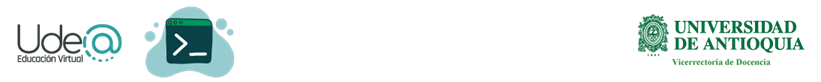


# Laboratorio #7 TDSIII
# Laboratorio Regresion lineal, Regularizacion, inferencia y regresion Bayesiana
## Juan Camilo Chaparro Castellanos | Sebastian Escobar Osorio
## CC 1039466438 | CC 1017231742

In [10]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as skl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from ipywidgets import interact
%matplotlib inline


def normalizar(x):
  nMax = np.max(x)
  nMin = np.min(x)
  norm = []
  for i in x:
    z = (i-nMin)/(nMax-nMin)
    norm.append(z)
  return norm

## 1. Base de datos y visualizar oil temperature

#### Procedemos a realizar la descargar el csv denominado "ETTh1" del repositorio : https://github.com/zhouhaoyi/ETDataset

In [2]:
!wget 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv'

--2024-11-10 17:34:27--  https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589657 (2.5M) [text/plain]
Saving to: 'ETTh1.csv.1'

ETTh1.csv.1         100%[===================>]   2.47M  1.85MB/s    in 1.3s    

2024-11-10 17:34:29 (1.85 MB/s) - 'ETTh1.csv.1' saved [2589657/2589657]



#### Procedemos a realizar lectura del archivo y normalizar los datos para poder realizar un posterior analisis

In [3]:
dataframe = pd.read_csv('./ETTh1.csv')
dataframe

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [12]:
valores= dataframe['OT'].values
dias = dataframe['date'].values
X = np.arange(0, 10000)
Y = valores[0:10000]

In [13]:
# Normalización
YN = normalizar(Y)
YN = YN[0:10000]

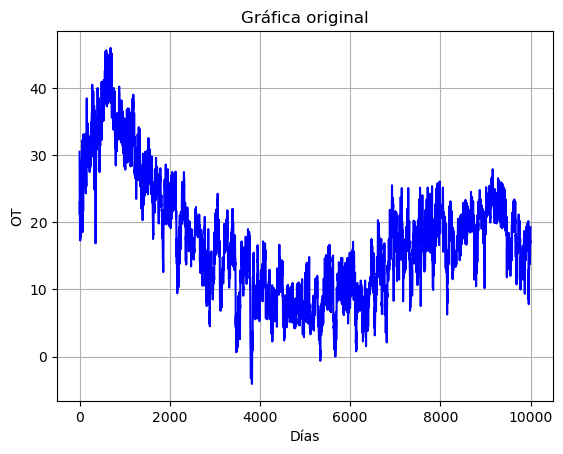

In [14]:
plt.plot(X,Y, color='b')
plt.title('Gráfica original')
plt.xlabel('Días')
plt.ylabel('OT')
plt.grid()

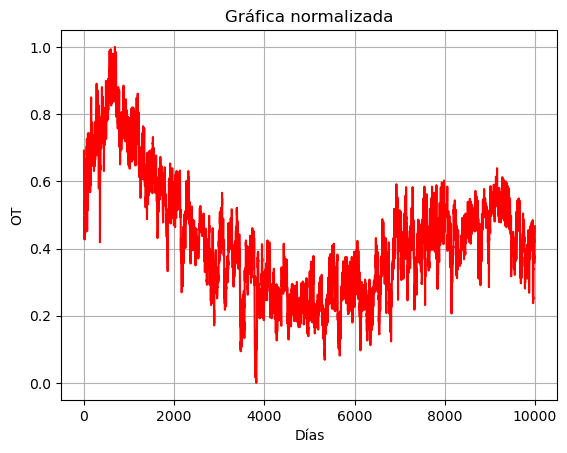

In [15]:
plt.plot(X,YN, color='r')
plt.title('Gráfica normalizada')
plt.xlabel('Días')
plt.ylabel('OT')
plt.grid()

## 2. Particion de base de datos

#### Procedemos a dividir la base de datos utilizando particion aleatoria de la siguiente manera
* #### 70% entrenamiento
* #### 30% test

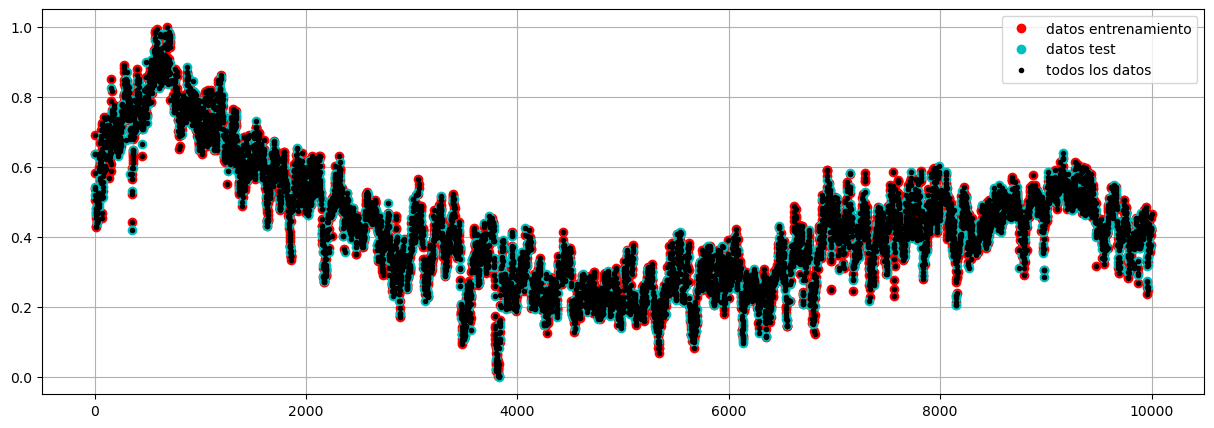

In [18]:
corte = int(0.7*len(X)) #corte 

Xs, ys = skl.utils.shuffle(X, YN) #Mezcla
Xtrain = Xs[0:corte] # 70% entrenamiento
Ytrain = ys[0:corte]

Xtest = Xs[corte:] # 30% test
Ytest = ys[corte:]

plt.figure(figsize=(15,5))
plt.plot(Xtrain, Ytrain, 'or')
plt.plot(Xtest, Ytest, 'oc')
plt.plot(X, YN, '.k')
plt.legend(['datos entrenamiento', 'datos test', 'todos los datos'])
plt.grid()
plt.show()

## 3. Funciones exponenciales como funciones base y parametros de modelo MAP y MLE 

#### declaramos las funciones que se pretenden utilizar para realizar la estimacion del modelo

In [49]:
                                                    #Funcion exponencial base
def expo_carac(X, K):
  # Extraer caracteristicas exponenciales
  # X: N x D, vector de entradas
  # K: escalar, grado del polinomio
  # return: N x (K+1), matriz de características Phi

  X = X.flatten()
  N = X.shape[0]

  #inicializar Phi
  Phi = np.ones((N, K+1))
  U = np.linspace(0,69680,K)
  sig2 = 6000

  # Calcular matriz Phi
  for k in range(1, K+1):
      Phi[:,k] = np.exp(-(U[k-1] - X)**2/(2*sig2))
  return Phi

                                                    #Máximo a posteriori (MAP)

def inferencia_max_posterior_carac(Phi, y, sigma, alpha):
  # Phi: N x D, características de entrada
  # y: D x 1, datos de salida
  # sigma: escalar, desviación estandar del ruido
  # alpha: escalar, desviación estandar del prior sobre los parámetros
  # return: D x 1,  estimación MAP theta_map

  D = Phi.shape[1]

  # SOLUTION
  PP = Phi.T @ Phi + (sigma/alpha)**2 * np.eye(D)
  theta_map = sp.linalg.solve(PP, Phi.T @ y)

  return theta_map


def plot_prediccion(X, Y, prediccion, trainX, trainY, testX, testY):
  # Gráfica predicción

  #plt.plot(trainX, trainY, '.r', label='datos de entrenamiento')
  #plt.plot(testX, testY, '.g', label='datos de prueba')
  plt.plot(X, Y, label='función real')
  plt.plot(X, prediccion, '--', lw=2, label='predicción')
  plt.legend()

                                                #RMSE
def rmse(y, y_pred):
  # Calculo función de error
  #y = y.flatten()
  y_pred = y_pred.flatten()
  N = len(y)
  difer = (y - y_pred)**2
  return np.sqrt((1.0/N) * np.sum(difer))

                                                #MAX VEROSIMILITUD
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados

    kappa = 1e-08 # jitter
    D = Phi.shape[1]

    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y
    return theta_ml

In [80]:
@interact(K = (1,500,2), sigma = (0.001, 1, 0.01), alpha=(0.001, 1, 0.01))

def RegresionMAP(K, sigma, alpha):

  Phi = expo_carac(Xtrain, K) # características datos entrenamiento

  theta_map = inferencia_max_posterior_carac(Phi, Ytrain, sigma, alpha)
  theta_ml = inferencia_max_vero_carac(Phi, Ytrain)


  # predicción sobre todos los datos (Test)
  Phi_test = expo_carac(X, K)
  y_pred_map = Phi_test @ theta_map  # Predicción usando MAP
  y_pred_ml = Phi_test @ theta_ml    # Predicción usando ML
    
    # Graficar resultados
  plt.figure(figsize=(10, 5))
  plt.plot(X, y_pred_ml, label="predicción MaxVero", color='red')
  plt.plot(X, y_pred_map, label="predicción MaxPos", color='orange')
  plt.scatter(Xtrain, Ytrain, color='blue', s=5, label="datos entrenamiento")
  plt.title(f'Predicción con k = {K}')
  plt.ylim(-0.2, 1)
  plt.legend()
  plt.grid()
  plt.show()

  # Métricas de rendimiento
  print('MSE (MAP):', mean_squared_error(YN, y_pred_map))
  print('MAE (MAP):', mean_absolute_error(YN, y_pred_map))
  print('R2 (MAP):', r2_score(YN, y_pred_map))


interactive(children=(IntSlider(value=249, description='K', max=500, min=1, step=2), FloatSlider(value=0.491, …

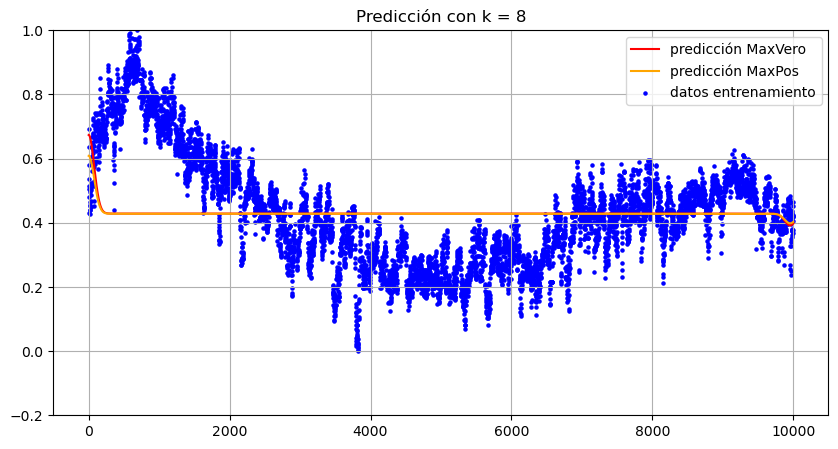

MSE (MAP): 0.029500025602216772
MAE (MAP): 0.13481391692460387
R2 (MAP): 0.011124464895049813


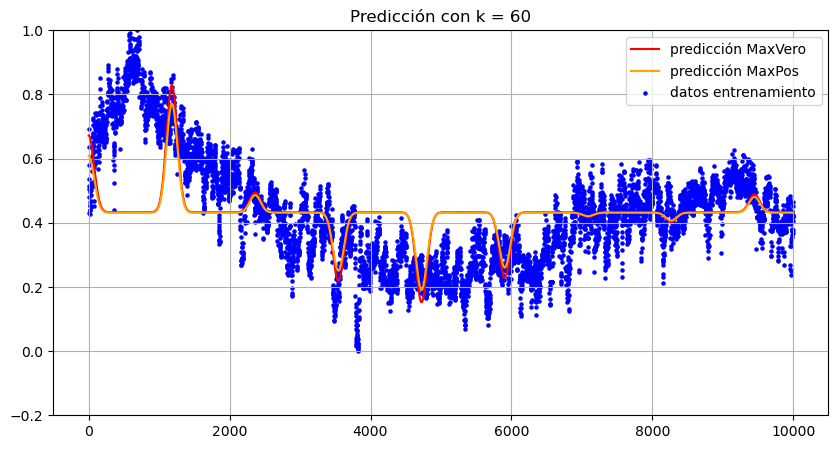

MSE (MAP): 0.02504058912165471
MAE (MAP): 0.11951788645352812
R2 (MAP): 0.16061001773643346


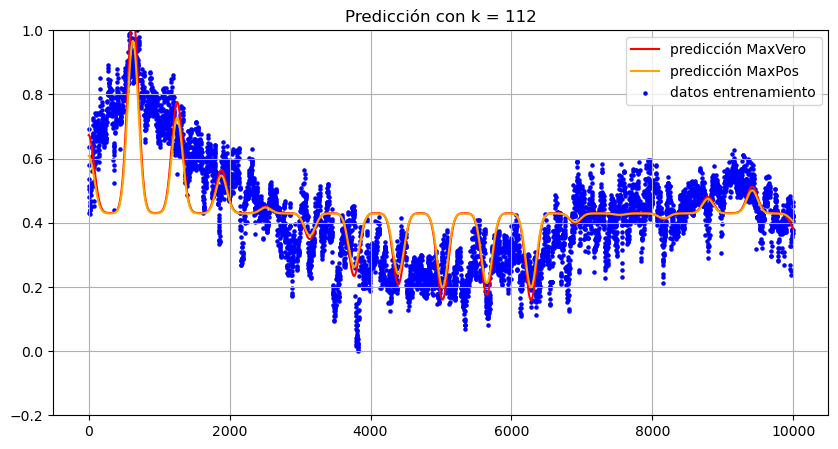

MSE (MAP): 0.01799447549031669
MAE (MAP): 0.10371767438733973
R2 (MAP): 0.3968040292791244


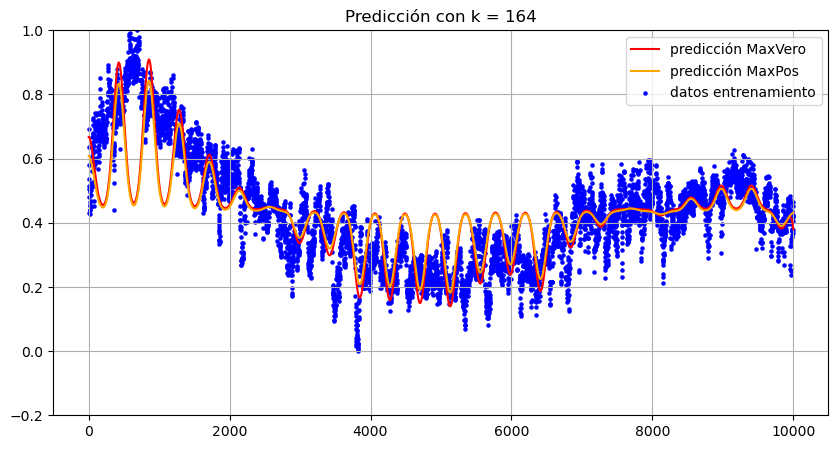

MSE (MAP): 0.014639000267101795
MAE (MAP): 0.08894299659402877
R2 (MAP): 0.5092835030812993


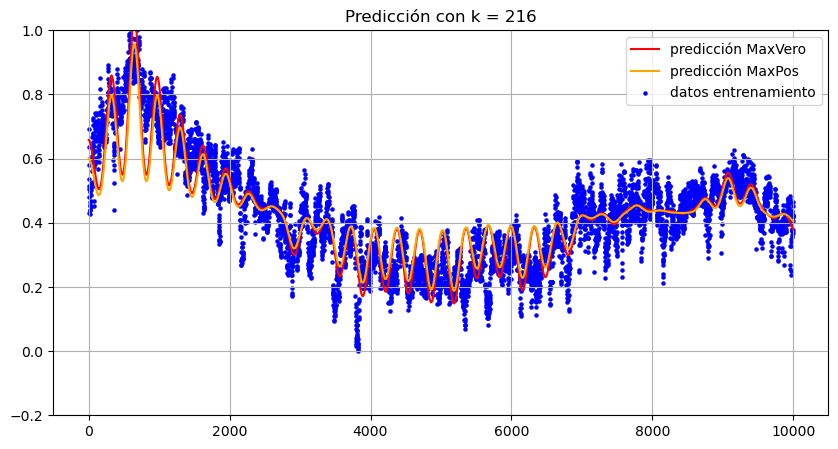

MSE (MAP): 0.008539983251101793
MAE (MAP): 0.06971442144582149
R2 (MAP): 0.7137297227773931


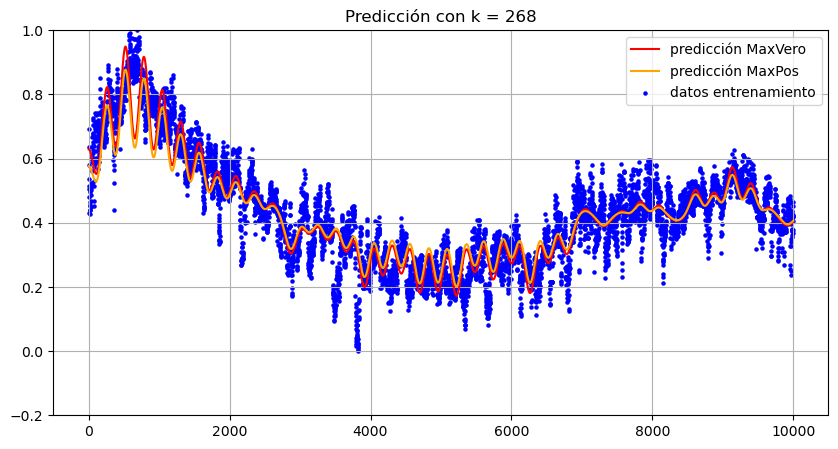

MSE (MAP): 0.006394044594694452
MAE (MAP): 0.05977431978185225
R2 (MAP): 0.7856641090647645


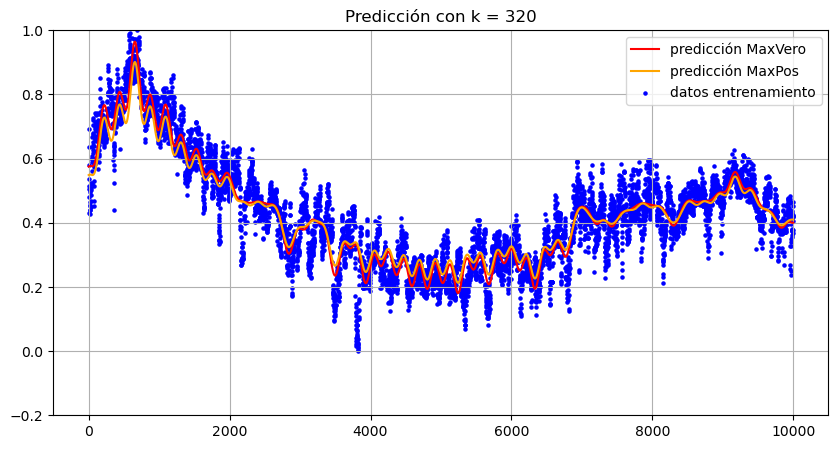

MSE (MAP): 0.0043869131576360606
MAE (MAP): 0.050786727511863757
R2 (MAP): 0.8529455141933735


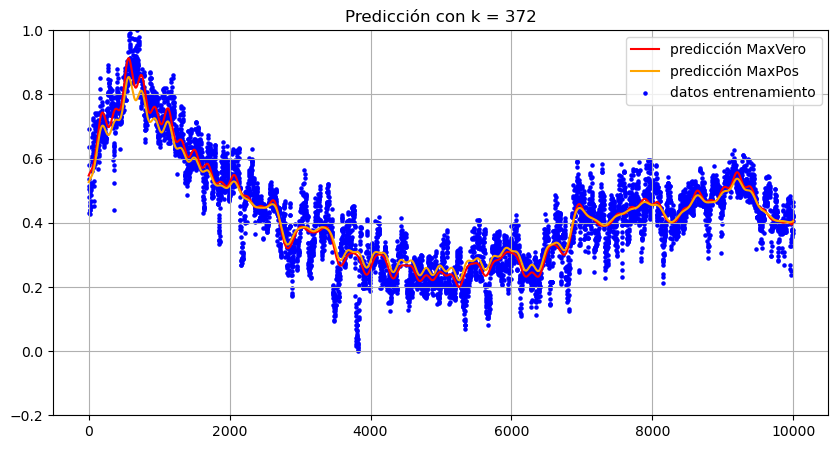

MSE (MAP): 0.004138787423674809
MAE (MAP): 0.049109092426484466
R2 (MAP): 0.8612629804645147


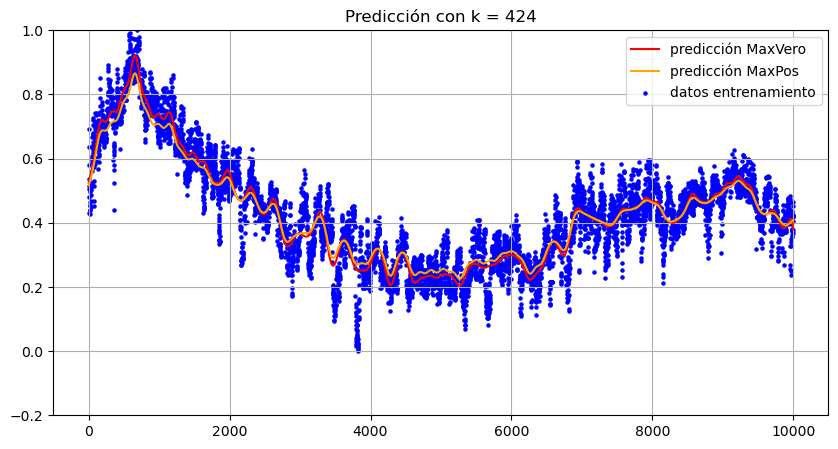

MSE (MAP): 0.003865397417926592
MAE (MAP): 0.04764463424320724
R2 (MAP): 0.870427334823797


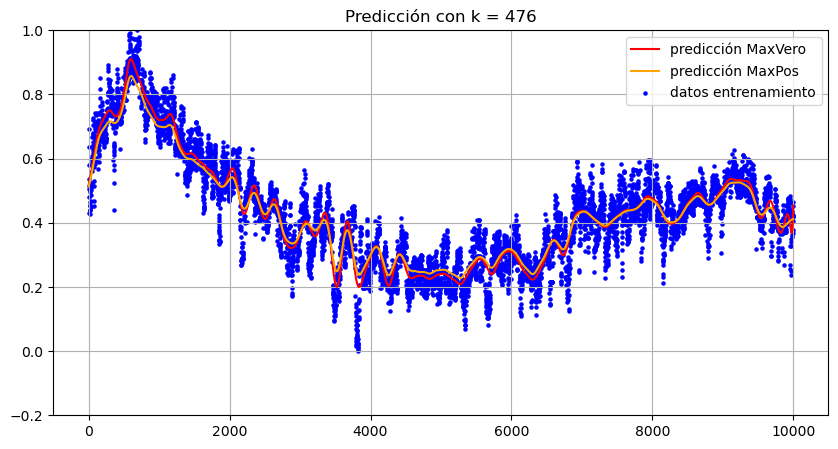

MSE (MAP): 0.0035229017720186553
MAE (MAP): 0.0456579357017297
R2 (MAP): 0.8819081914740663


In [92]:
import random

inicio = 8
paso = 52
total_elementos = 10

k_values = np.arange(inicio, inicio + paso * total_elementos, paso)
sigma = 0.6 # Desviación estándar del ruido
alpha = 0.15 # Desviación estándar del parámetro prior

for i in range(len(k_values)):

  RegresionMAP(k_values[i], sigma, alpha)

#### Procedemor a realizar el siguiente analisis de los resultados :




## 4. Calculo de MSE

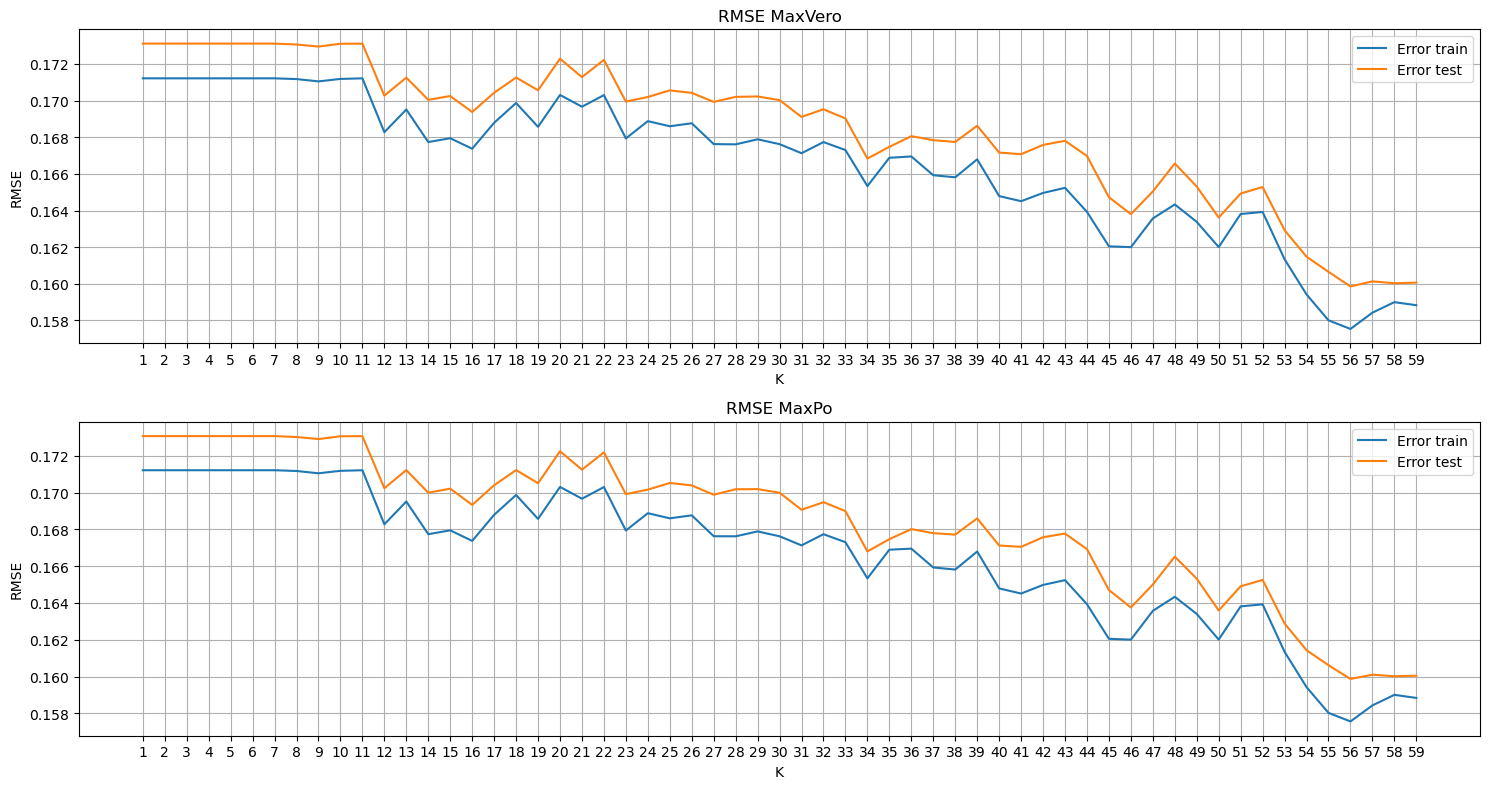

In [90]:
rmse_train_mle = []
rmse_test_mle = []

rmse_train_map = []
rmse_test_map = []

K_vector = []

K_max = 60

if K_max <= 100:
    cons=1
else:
    cons=10

for i in range(1, K_max,cons):
    K = i

    Phi_train = expo_carac(Xtrain, K)

    theta_mle = inferencia_max_vero_carac(Phi_train, Ytrain)
    theta_map = inferencia_max_posterior_carac(Phi_train, Ytrain,sigma,alpha)

    #Medicion Error
    y_pred_mle = Phi_train @ theta_mle # predicción
    rmse_train_mle.append(rmse(Ytrain, y_pred_mle)) # medir error
    y_pred_map = Phi_train @ theta_map # predicción
    rmse_train_map.append(rmse(Ytrain, y_pred_map)) # medir error

    # predicción sobre datos de test
    Phi_test = expo_carac(Xtest, K)

    #Medicion test
    y_pred_mle = Phi_test @ theta_mle # predicción
    rmse_test_mle.append(rmse(Ytest, y_pred_mle)) # medir error
    y_pred_map = Phi_test @ theta_map # predicción
    rmse_test_map.append(rmse(Ytest, y_pred_map)) # medir error

    K_vector.append(i)

#Maxima verosimilitud
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(K_vector, rmse_train_mle, '-', label='Error train')
plt.plot(K_vector, rmse_test_mle, '-', label='Error test')
plt.xticks(K_vector)
plt.title('RMSE MaxVero')
plt.ylabel('RMSE')
plt.xlabel('K')
plt.legend()
plt.tight_layout()
plt.grid()

#Maximo a posteriori
plt.subplot(2,1,2)
plt.plot(K_vector, rmse_train_map, '-', label='Error train')
plt.plot(K_vector, rmse_test_map, '-', label='Error test')
plt.xticks(K_vector)
plt.title('RMSE MaxPo')
plt.ylabel('RMSE')
plt.xlabel('K')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#### Analisis
* #### ¿Cuál es el número en funciones base correspondiente al modelo con mejor capacidad de generalización?

  El numero de dunciones base M correspondiente al modelo con mejor capacidad de generalización en este caso es de 80 aproximadamente, ya que es el que toma la mayoria de los datos.
  
* #### ¿El MSE entre las predicciónes y los datos de entrenamiento también es mínimo para ese mismo valor ?

Para el metodo de maxima verosimilitud el minimo no es igual, es muy cercano a 60 y en M=80 el error se dispara considerablemente. Sin embargo para el método de máximo posteriori el minimo esta entre 60 y 80, que tiende a estabilizarse, por lo que para M=80 el error no cambia mucho.

* #### ¿Qué método (MAP o MLE) obtiene un mejor desempeño respecto a número de funciones base vs. el error?

El método que mejor desempeño obtiene respecto al número de funciones base vs el error es el MAP (Maximo a posteriori), debido a que regulariza un poco mejor el error y trata de estandarizar los datos, por lo que se puede concluir que el MAP es un algoritmo mas robusto frente al sobreentrenamiento. El MLE (MAxima verosimilitud) despues de un numero de funciones base aparece un sobreajuste grave por lo que el error se dispara.


otras respuestas
  
- De la gráfica de errores se observa que el error de test se mantiene por encima del error obtenido de train. Cabe destacar que ambos errores son muy "parejos" y tienen la misma tendencia a lo largo del análisis con algunas variaciones, es decir, alcanzan mínimos valores de $RMSE$ al mismo tiempo. Además, se confirma lo que se ha venido mencionando en cuanto a que el error entre las estimaciones y los datos originales disminuye al emplear un número mayor de funciones exponenciales.

- En sí no alcanzamos a observar bien un punto fijo de generalización porque a medida que se incrementa el número de funciones base el modelo va teniendo un mejor rendimiento en cuanto a la estimación. Un ejemplo de esto es que desde $K\approx320$, se obtienen un muy buen desempeño debido a que las estimaciones encontradas son bastante similares a las etiquetas originales.

## 5. Regresion Lineal Bayesiana